In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# Define paths and constants
results_dir = "../results/num_iters"
lmax = 5
num_iters = 100000

# Load all batch results
all_results = []

# Define batch ranges based on the file names
batch_ranges = [
    (0, 42), (42, 84), (84, 126), (126, 168), (168, 210),
    (210, 252), (252, 294), (294, 336), (336, 378), (378, 420),
    (420, 462), (462, 504), (504, 546), (546, 588), (588, 630),
    (630, 672), (672, 714), (714, 756), (756, 798), (798, 840),
    (840, 882), (882, 924), (924, 966), (966, 1008)
]

# Process each batch file
best_pred_histories = []
for start, end in batch_ranges:
    filename = f"qm9_inversion_bispectrum_lmax_{lmax}_num_iters_{num_iters}_batch_{start}_{end}.pkl"
    filepath = os.path.join(results_dir, filename)
    
    try:
        with open(filepath, "rb") as f:
            batch_results = pickle.load(f)
            if "best_pred_histories" in batch_results:
                best_pred_histories.extend(batch_results["best_pred_histories"])
            else:
                print(f"Warning: 'best_pred_histories' not found in {filepath}")
            all_results.append(batch_results)
        print(f"Loaded results from {filepath}")
    except Exception as e:
        print(f"Error loading {filepath}: {str(e)}")

# Limit to first 1000 histories if we have that many
if len(best_pred_histories) > 1000:
    best_pred_histories = best_pred_histories[:1000]

Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_0_42.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_42_84.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_84_126.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_126_168.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_168_210.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_210_252.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_252_294.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_294_336.pkl
Loaded results from ../results/num_iters/qm9_inversion_bispectrum_lmax_5_num_iters_100000_batch_336_378.pkl
Loaded results from ../results/num

In [2]:
with open('../data/qm9_local_envs_10000.pkl', 'rb') as f:
    local_envs = pickle.load(f)

print(f"Number of local environments: {len(local_envs)}")

Number of local environments: 10000


In [3]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_dir = os.path.join(project_root, 'src')
sys.path.append(src_dir)
import spectra as spectra
from utils.plotters import visualize_signal
from utils.alignment import sample_uniform_quaternion, find_best_random_quaternion, align_signals, choose_best_quaternion, loss_fn, quaternion_rotation_distance, rotate_points_quaternion, point_distance, find_best_random_quaternions
from utils.geometries import trigonal_plane, tetrahedron, trigonal_bipyramid
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
import numpy as np
from scipy.spatial.transform import Rotation
import itertools
from tqdm import tqdm


def align_predicted_geometry(true_geometry: np.ndarray,
                             predicted_geometry: np.ndarray
                            ) -> tuple[np.ndarray, float]:
    """
    Aligns `predicted_geometry` onto `true_geometry` using only a rigid-body rotation.
    Points are first sorted by distance from the origin, normalized to unit radius,
    then each pair of corresponding direction‐vectors is scaled by a different
    random weight (to break any geometric symmetry) before computing the optimal
    rotation. Assumes both inputs are centered at the origin.

    Parameters
    ----------
    true_geometry : (N, 3) array_like
        Reference point cloud, centered at the origin.
    predicted_geometry : (N, 3) array_like
        Point cloud to align, also centered.

    Returns
    -------
    aligned_predicted : (N, 3) ndarray
        The `predicted_geometry` rotated to best match `true_geometry`.
    rmsd : float
        The RMSD between the (weighted) direction‐vectors after optimal alignment.
    """
    # Convert inputs
    true_pts = np.asarray(true_geometry, dtype=float)
    pred_pts = np.asarray(predicted_geometry, dtype=float)
    if true_pts.shape != pred_pts.shape or true_pts.shape[1] != 3:
        raise ValueError("Both inputs must have shape (N, 3)")

    # Compute norms (radii) without sorting
    true_radii = np.linalg.norm(true_pts, axis=1)
    pred_radii = np.linalg.norm(pred_pts, axis=1)
    
    # Normalize to unit vectors directly without reordering
    true_dirs = true_pts / true_radii[:, None]
    pred_dirs = pred_pts / pred_radii[:, None]    

    # Generate a different random weight for each point to break symmetry
    # (e.g. uniform on [0,1) or any other distribution)
    weights = np.random.rand(true_dirs.shape[0], 1)

    # Scale both sets by the same per-point weights
    true_weighted = true_dirs * weights
    pred_weighted = pred_dirs * weights

    # Compute optimal rotation on weighted directions
    rot, rmsd = Rotation.align_vectors(true_weighted, pred_weighted)

    # Apply rotation back to the original predicted points
    pred_rotated = rot.apply(pred_pts)

    return pred_rotated, rmsd


def alignment_mae(true_geometry, predicted_geometry):

    if len(true_geometry) != len(predicted_geometry):
        return float('inf'), None

    # Try all permutations of the predicted geometry and select the one with lowest RMSD
    best_error = float('inf')
    best_aligned = None
    
    # Get all permutations of indices
    n_points = predicted_geometry.shape[0]
    for perm in itertools.permutations(range(n_points)):
        perm_predicted = predicted_geometry[list(perm)]
        aligned, _ = align_predicted_geometry(true_geometry, perm_predicted)
        error = jnp.mean(jnp.linalg.norm(aligned - true_geometry, axis=1))
        # error = np.mean(np.abs(aligned - true_geometry), axis=1)
        if error < best_error:
            best_error = error

    return best_error

In [14]:
all_maes = []
for index, history in tqdm(enumerate(best_pred_histories)):
    maes = []
    for iter in range(0, len(history), 2000):
        pred = history[iter]
        true = local_envs[42*(index+1)-1]
        mae = alignment_mae(true, pred)
        maes.append(mae)
    all_maes.append(maes)
all_maes = np.array(all_maes)

24it [00:01, 22.24it/s]


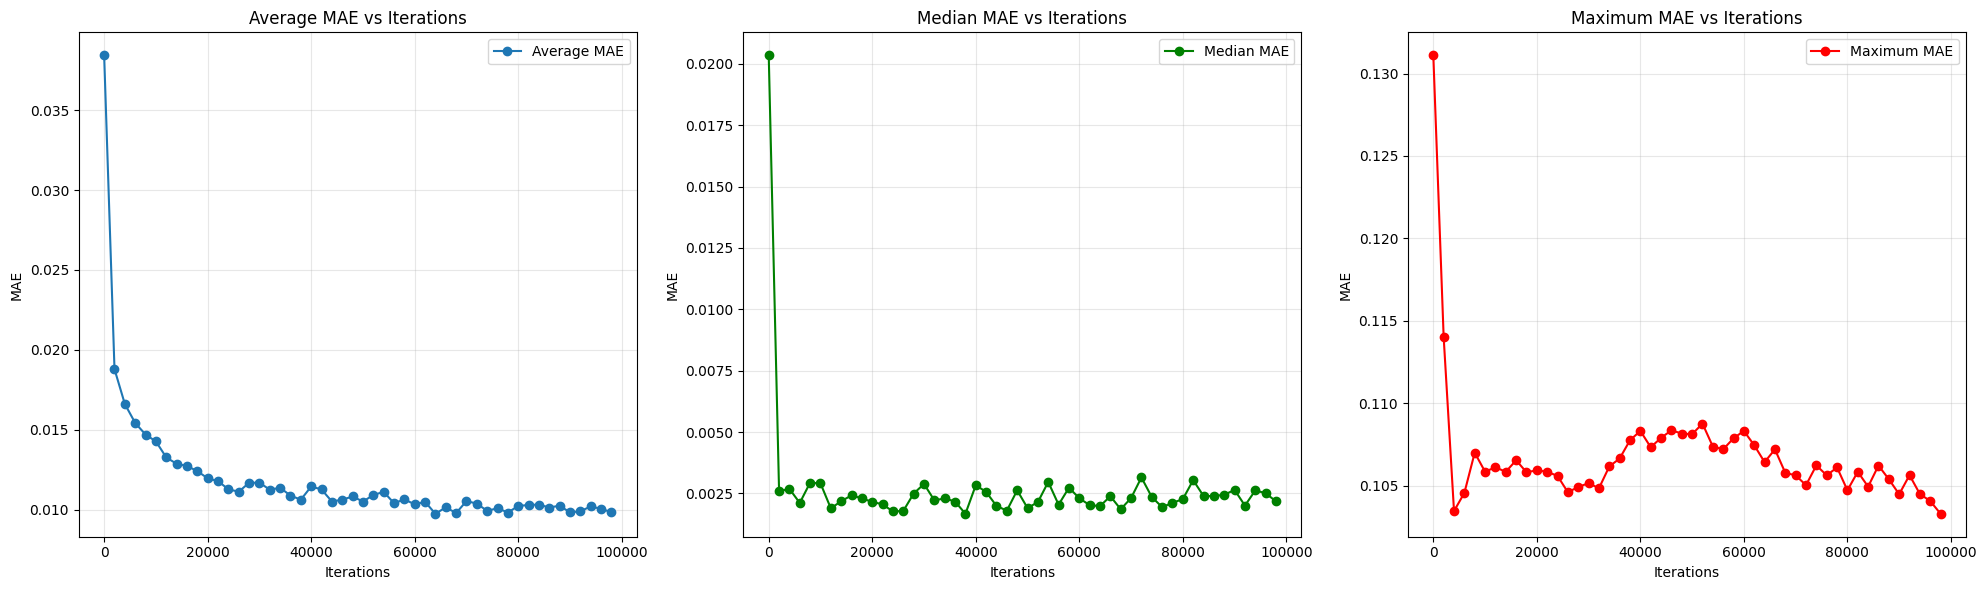

In [15]:
# Visualize the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Create a mask for non-Inf values and replace Inf with NaN for calculations
mask = ~np.isinf(all_maes)
masked_values = np.where(mask, all_maes, np.nan)

# Plot average MAE
avg_mae = np.nanmean(masked_values, axis=0)
iterations = np.arange(0, len(all_maes[0])) * 2000
ax1.plot(iterations, avg_mae, 'o-', label='Average MAE')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('MAE')
ax1.set_title('Average MAE vs Iterations')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Calculate median MAE
median_mae = np.nanmedian(masked_values, axis=0)
ax2.plot(iterations, median_mae, 'o-', color='green', label='Median MAE')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('MAE')
ax2.set_title('Median MAE vs Iterations')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Calculate max MAE
max_mae = np.nanmax(masked_values, axis=0)
ax3.plot(iterations, max_mae, 'o-', color='red', label='Maximum MAE')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('MAE')
ax3.set_title('Maximum MAE vs Iterations')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

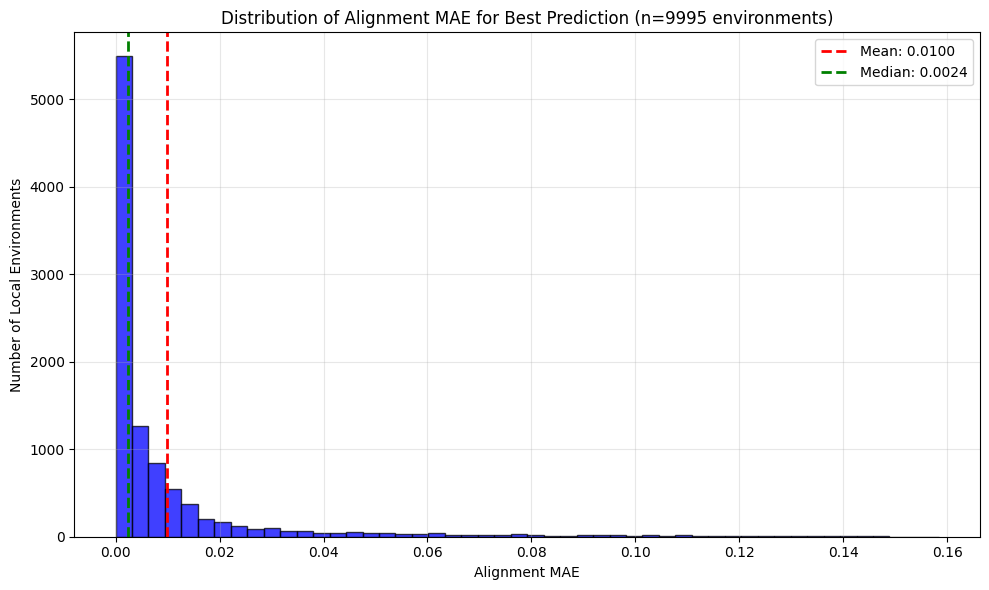

In [8]:
# Plot histogram of alignment MAE for the last (best) prediction
plt.figure(figsize=(10, 6))

# Get the MAE values for the last initialization (best prediction)
# Filter out inf values for better visualization
last_init_mae = best_alignment_mae_per_init[:, -1]
valid_mae = last_init_mae[~np.isinf(last_init_mae)]

# Create histogram
plt.hist(valid_mae, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Alignment MAE')
plt.ylabel('Number of Local Environments')
plt.title(f'Distribution of Alignment MAE for Best Prediction (n={len(valid_mae)} environments)')
plt.grid(True, alpha=0.3)

# Add statistics to the plot
plt.axvline(np.mean(valid_mae), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(valid_mae):.4f}')
plt.axvline(np.median(valid_mae), color='green', linestyle='dashed', linewidth=2, label=f'Median: {np.median(valid_mae):.4f}')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()


In [61]:
# Count the number of False values in each column of mask
false_counts = np.sum(~mask, axis=0)
print("Number of False values in each column (initialization):")
for i, count in enumerate(false_counts):
    print(f"Initialization {i+1}: {count} False values")

Number of False values in each column (initialization):
Initialization 1: 56 False values
Initialization 2: 12 False values
Initialization 3: 4 False values
Initialization 4: 6 False values
Initialization 5: 4 False values
Initialization 6: 4 False values
Initialization 7: 4 False values
Initialization 8: 4 False values
Initialization 9: 3 False values
Initialization 10: 3 False values
Initialization 11: 4 False values
Initialization 12: 5 False values
Initialization 13: 5 False values
Initialization 14: 5 False values
Initialization 15: 5 False values
Initialization 16: 5 False values
Initialization 17: 5 False values
Initialization 18: 5 False values
Initialization 19: 5 False values
Initialization 20: 5 False values
